# Recommender System

## Introduction
### Objective:
Engineer a product recommendation system for an e-commerce website to increase customer retention and sales.

**Featured Techniques:**

1) Feature Engineering <br>
2) Collaborative Filtering <br>
3) Surprise Package SVD <br>

### Methodology:
Users are separated into repeat customers and first time customers and the recommendation system works as follows.

**Repeat Customers**<br>
1) Collaborative filtering recommendation <br>
2) Hot Products <br>
3) Popular in your area <br>

**New Customers**<br>
1) Hot products <br>
2) Popular in your area <br>

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

import psycopg2 as pg
import pandas.io.sql as pd_sql
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

from sqlalchemy import create_engine

from scipy import stats

from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD, SVDpp, KNNBasic, CoClustering, SlopeOne
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

C:\Users\rachc\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
olist_combined = pd.read_csv('OlistRecommenderDataProductName.csv', low_memory=False)

In [3]:
olist_combined.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'order_id', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'order_status',
       'order_purchase_timestamp', 'order_estimated_delivery_date',
       'order_item_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_id', 'product_category_name', 'product_category_name_english',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_id', 'seller_city', 'seller_state', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'total_payment', 'product_name',
       'Product Category'],
      dtype='object')

In [4]:
# some purchases are payed with by vouchers which causes them to split into many lines of
# smaller payments. To normalize with the rest of the data, combining these values into 
# one total payment value

def create_total_payment_value(data):
    data['total_payment'] = data['payment_value'].groupby(data['order_id']).transform('sum')
    data= data.drop('payment_value', axis=1)
    return data

In [5]:
def duplicates(data):
    """
    Prints the number of duplicates in the input dataset, removes duplicate values keeping only the 
    first entry, and returns a dataset with no duplicate values.
    """
    
    # Confirm number of duplicate rows
    print(f"There are {data.duplicated().sum()} duplicate rows.")

    # Remove any duplicates, keeping only the first entry
    data = data.drop_duplicates(keep='first')

    # Confirm duplicates were removed correctly
    print(f"After dropping, there are {data.duplicated().sum()} duplicate rows.")
    print(f"Returned dataset has {data.shape[0]} rows")
    
    return data

In [6]:
olist_data = create_total_payment_value(olist_combined)

In [7]:
olist_data = duplicates(olist_data)

There are 0 duplicate rows.
After dropping, there are 0 duplicate rows.
Returned dataset has 100851 rows


In [10]:
olist_data.describe([.75,.99])

,Unnamed: 0,Unnamed: 0.1,payment_sequential,payment_installments,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_id,customer_zip_code_prefix,review_score,total_payment
count,100851.000000,100851.000000,100851.000000,100851.000000,100851.000000,100851.000000,100851.000000,99362.000000,99362.000000,99362.000000,100835.000000,100835.000000,100835.000000,100835.000000,100851.000000,100851.000000,100851.000000,100851.000000,100851.000000
mean,50425.000000,50425.000000,1.091858,2.939346,1.198719,120.322252,20.025920,48.753668,785.137326,2.200187,2104.193157,30.242922,16.639213,23.070313,24480.424696,49637.209834,35046.036747,4.013049,358.960980
std,29113.320336,29113.320336,0.712193,2.776261,0.711144,184.124366,15.860981,10.039675,652.062160,1.713838,3767.479959,16.162962,13.443692,11.747344,27597.645374,28617.862645,29812.485840,1.402232,1671.336309
min,0.000000,0.000000,1.000000,0.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1.000000,1003.000000,1.000000,9.590000
50%,50425.000000,50425.000000,1.000000,2.000000,1.000000,74.900000,16.310000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13613.000000,49633.000000,24240.000000,5.000000,127.170000
75%,75637.500000,75637.500000,1.000000,4.000000,1.000000,134.900000,21.180000,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28630.000000,74404.500000,58410.000000,5.000000,259.360000
99%,99841.500000,99841.500000,3.000000,10.000000,4.000000,889.550000,85.255000,63.000000,3417.170000,8.000000,18350.000000,95.000000,65.000000,62.000000,93542.000000,98416.500000,97574.500000,5.000000,3791.460000
max,100850.000000,100850.000000,29.000000,24.000000,21.000000,6735.000000,409.680000,76.000000,3985.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,99440.000000,99990.000000,5.000000,109312.640000


## Recommender related EDA :

## 1) Consumer centric :

In [11]:
olist_blue  = '#007FAA'
olist_green = '#0CC78B'

In [13]:
def general_customer_info(data):
    """Returns number of unique and repeat customers in the dataset."""
    print("Number of unique customers:", data.customer_unique_id.nunique())
    
    customer_count = data.customer_unique_id.value_counts()
    print("Number of repeat customers:", customer_count[customer_count > 1].count())

    return

general_customer_info(olist_data)

Number of unique customers: 81662
Number of repeat customers: 12097


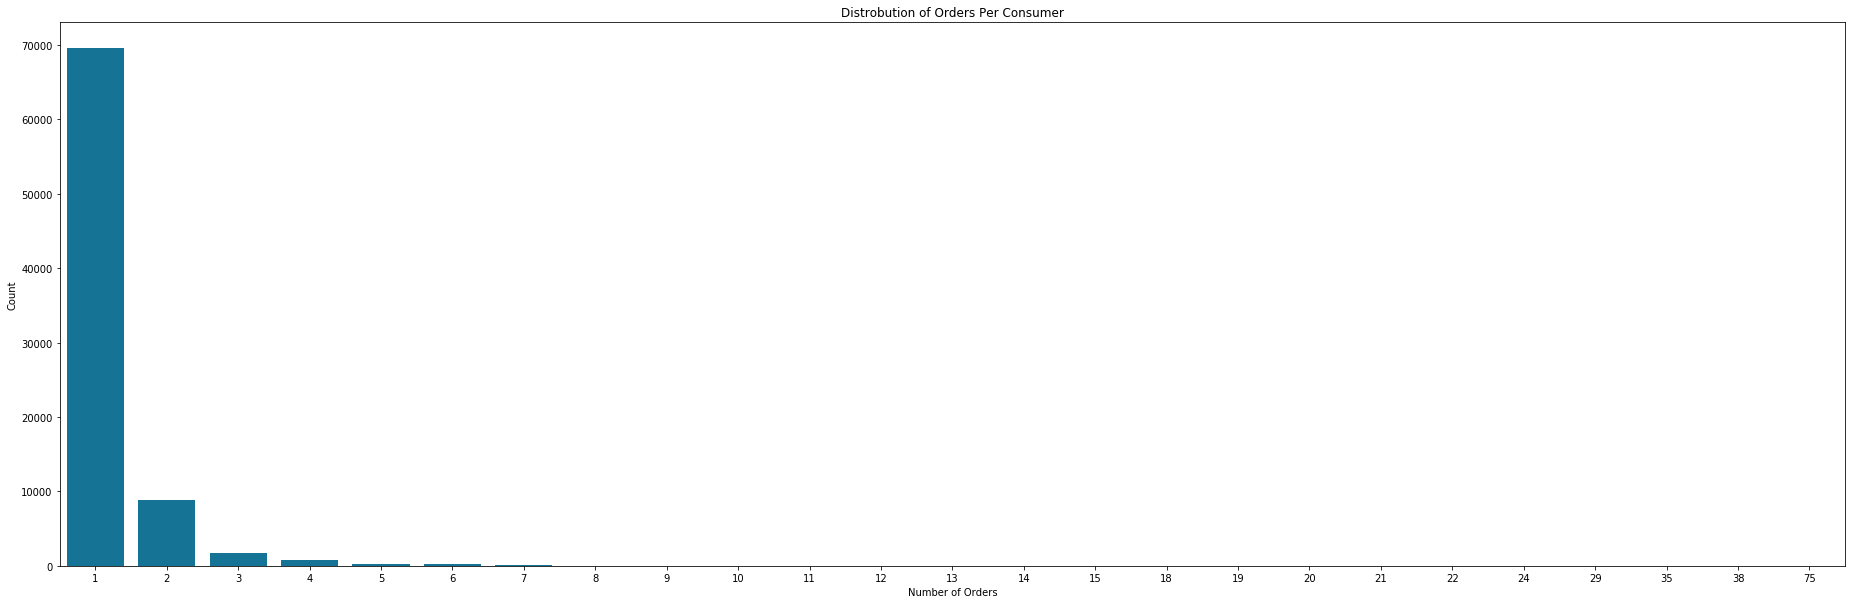

In [14]:

# Distrobution of orders per customer

def order_per_consumer(data):
    return data.groupby('customer_unique_id')['order_id'].agg(['count'])
    
orders_per_consumer = order_per_consumer(olist_data)

fig = plt.figure(figsize=(32,10))
ax = fig.gca()
sns.countplot(orders_per_consumer['count'], color=olist_blue)
ax.set(xlabel='Number of Orders', ylabel='Count', title='Distrobution of Orders Per Consumer');
#double click on image for a better examination

In [15]:
# Customer locations throughout Brazil

def customer_geography(data):
    customer_locations = pd.DataFrame(data.customer_city.value_counts().sort_values(ascending=False))
    customer_locations = customer_locations(olist_data).reset_index().rename(columns={'index': 'city', 'customer_city':'num_customers'})
    
    print(f"There are {customer_locations.city.nunique()} unique customer cities.\n")
    
    top_ten_cities = customer_locations.city[:10]
    customers_in_top_ten_cities = round(customer_locations.num_customers[:10].sum()/customer_locations.num_customers.sum()*100,2)

    print(f"The majority of customers, {customers_in_top_ten_cities} percent, live in the top ten cities.\n")

    return customer_locations, top_ten_cities

In [16]:
olist_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'order_id', 'payment_sequential',
       'payment_type', 'payment_installments', 'order_status',
       'order_purchase_timestamp', 'order_estimated_delivery_date',
       'order_item_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_id', 'product_category_name', 'product_category_name_english',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_id', 'seller_city', 'seller_state', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'total_payment', 'product_name',
       'Product Category'],
      dtype='object')

In [17]:
customer_locations = pd.DataFrame(olist_data.customer_city.value_counts().sort_values(ascending=False))

In [18]:
customer_locations = customer_locations.reset_index().rename(columns={'index': 'city', 'customer_city':'num_customers'})

In [19]:
customer_locations

,city,num_customers
0,sao paulo,15849
1,rio de janeiro,7192
2,belo horizonte,2777
3,brasilia,2096
4,curitiba,1523
...,...,...
3927,missao velha,1
3928,palmares paulista,1
3929,serra dourada,1
3930,morro do ferro,1


In [20]:
top_ten_cities = customer_locations.city[:10]

In [21]:
customers_in_top_ten_cities = round(customer_locations.num_customers[:10].sum()/customer_locations.num_customers.sum()*100,2)
print(f"The majority of customers, {customers_in_top_ten_cities} percent, live in the top ten cities.\n")

The majority of customers, 35.52 percent, live in the top ten cities.



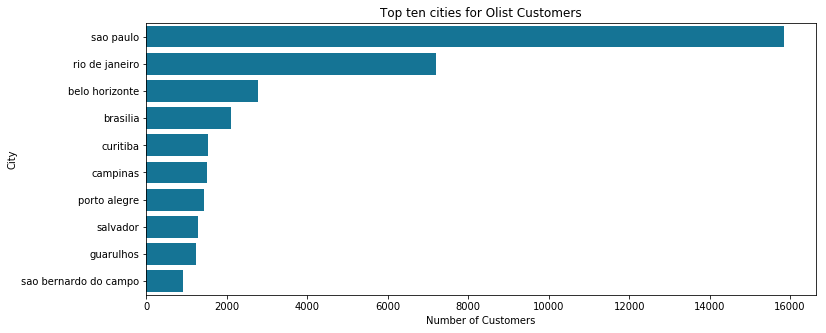

In [22]:
# plot top cities
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
sns.barplot(x=customer_locations.num_customers[:10], y=top_ten_cities, ax=ax, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='City', title='Top ten cities for Olist Customers');

## 2) Order centric :

In [25]:
def items_per_order(data):
    item_orders = data.groupby('order_id').product_id.agg(['count']).sort_values(by='count')
    avg_items_per_order = item_orders.mean()
    print(f"Average number of items per order: {avg_items_per_order}")
    return avg_items_per_order

avg_items_per_order = items_per_order(olist_data)

Average number of items per order: count    1.199351
dtype: float64


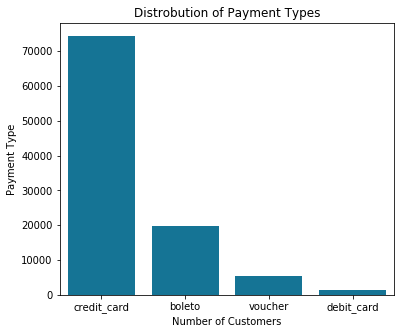

In [26]:

# Payment methods
def payment_types(data):
    return data.payment_type.value_counts()

payment_types = payment_types(olist_data)

fig = plt.figure(figsize=(6,5))
ax = fig.gca()
sns.barplot(x=payment_types.index, y=payment_types.values, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='Payment Type', title='Distrobution of Payment Types');

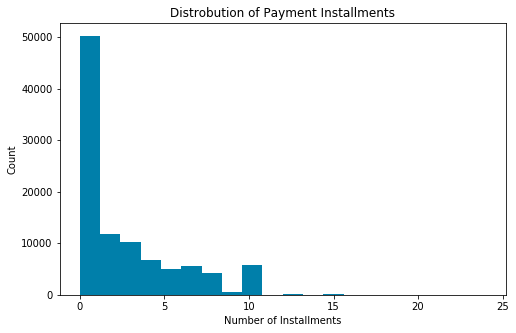

In [27]:

# Installments
plt.figure(figsize=(8,5))
plt.hist(olist_data.payment_installments, color=olist_blue, bins=20)
plt.xlabel('Number of Installments')
plt.ylabel('Count')
plt.title('Distrobution of Payment Installments');

Avg. number of sales per seller: 33.69562312061477

The top 10 sellers account for 14.18 percent of the total sales

The top seller has 1847 sales


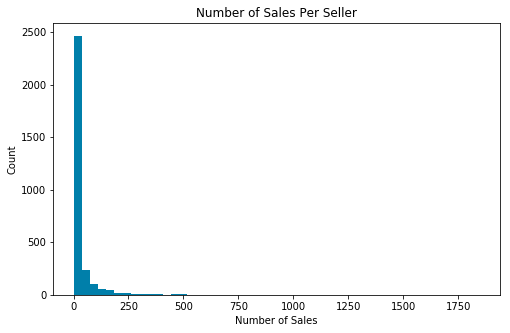

In [28]:
def sales_per_seller(data):
    """
    Returns the average number of sales per Olist seller, the magnitude of the top 10 sellers,
    and the number of sales that the top seller has made.
    """
    
    sales_per_seller = data.groupby('seller_id')['order_id'].count()
    print(f"Avg. number of sales per seller: {sales_per_seller.mean()}\n")
    
    top_ten_sellers = sales_per_seller.sort_values(ascending=False)[:10]
    sales_in_top_ten_sellers = round(top_ten_sellers.values.sum()/sales_per_seller.values.sum()*100,2)

    print(f"The top 10 sellers account for {sales_in_top_ten_sellers} percent of the total sales\n")

    print(f"The top seller has {top_ten_sellers[0]} sales")

    return sales_per_seller

sales_per_seller = sales_per_seller(olist_data)


plt.figure(figsize=(8,5))
plt.hist(sales_per_seller, bins=50, color=olist_blue)
plt.xlabel('Number of Sales')
plt.ylabel('Count')
plt.title('Number of Sales Per Seller');

Number of unique products: 29941

Average price per product: 120.32225183698651

Average sales per product: 3.3683243712634847

Top ten selling products:
Toasted Buttercrisp Crackers                               470
Stainless Steel Water Bottle With Sport Cap, Aqua Color    459
Clotted Cream, English Luxury                              406
Corn Pops Cereal                                           355
8\" Pepperoni Pizza                                        334
Crystals Lavender Blossom In-Wash Fragrance Booster        328
Sheep Milk Original Plain Kefir                            304
Traditional Non-Alcoholic Egg Nog                          274
Original Creole Seasoning                                  247
Max Cockroach Killer                                       240
Name: product_name, dtype: int64

The top ten selling products account for 3.39 percent of the product sold.



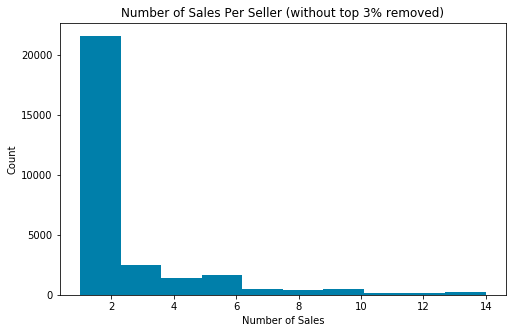

In [29]:
# Average product cost
def product_sales_info(data, olist_blue):
    """
    Identifies number of unique products sold at olist, the average price per product, the
    average number of sales per product. and a list of the top ten products. Plots the 
    distrobution of sales per product.
    """
    
    print(f"Number of unique products: {data.product_name.nunique()}\n")
    print(f"Average price per product: {data.price.mean()}\n")
    
    number_prod_sold = data.product_name.value_counts()
    print(f"Average sales per product: {np.mean(number_prod_sold)}\n")
    
    # top products
    top_ten_products = number_prod_sold[:10]
    print(f"Top ten selling products:\n{top_ten_products}\n")
    print(f"The top ten selling products account for {round(top_ten_products.values.sum()/number_prod_sold.values.sum()*100,2)} percent of the product sold.\n")

    p_q_97 = number_prod_sold.quantile(.97)
    products_q_97 = number_prod_sold[number_prod_sold < p_q_97]

    plt.figure(figsize=(8,5))
    plt.hist(products_q_97, bins=10, color=olist_blue)
    plt.xlabel('Number of Sales')
    plt.ylabel('Count')
    plt.title('Number of Sales Per Seller (without top 3% removed)');
    
    return

product_sales_info(olist_data, olist_blue)

The top reviewed products are
       product_id  mean  count
4437      P04885   5.0     44
27644     P30441   5.0     38
20274     P22328   5.0     21
1513      P01672   5.0     17
906       P01002   5.0     15
3804      P04179   5.0     15
4595      P05052   5.0     15
13506     P14877   5.0     14
23830     P26245   5.0     14
27816     P30633   5.0     14


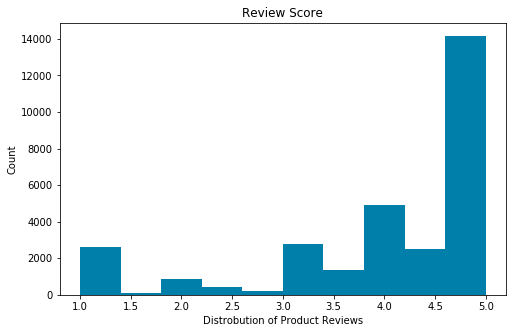

In [31]:
# Top reviewed products as determined by rating and number of reviews
def product_reviews(data):
    reviewed_products = data.groupby('product_id')['review_score'].agg(['mean', 'count']).reset_index()
    top_ten_reviewed_products = reviewed_products.sort_values(by=['mean','count'],ascending=False)[:10]

    print(f"The top reviewed products are\n {top_ten_reviewed_products}")
    
    return reviewed_products

reviewed_products = product_reviews(olist_data)


plt.figure(figsize=(8,5))
plt.hist(reviewed_products['mean'], bins=10, color=olist_blue)
plt.xlabel('Distrobution of Product Reviews')
plt.ylabel('Count')
plt.title('Review Score');

<Figure size 432x360 with 0 Axes>

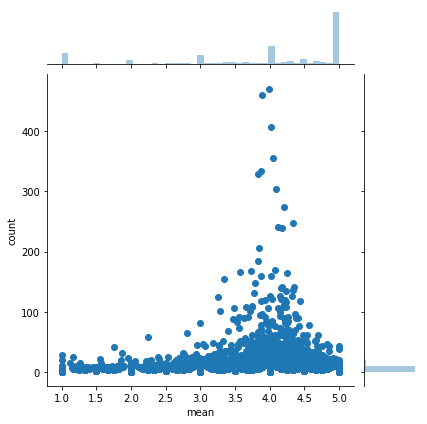

In [32]:
fig = plt.figure(figsize=(6,5))
ax = sns.jointplot(x=reviewed_products['mean'], y=reviewed_products['count'], data=reviewed_products);

In [33]:
olist_data.rename(columns={'Product Category':'product_category_new'}, inplace=True)

In [34]:
olist_data

,Unnamed: 0,Unnamed: 0.1,order_id,payment_sequential,payment_type,payment_installments,order_status,order_purchase_timestamp,order_estimated_delivery_date,order_item_id,...,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,total_payment,product_name,product_category_new
0,0,0,ON53096,1,credit_card,2,delivered,7/2/2018 18:05,7/25/2018 0:00,1,...,SP,PR43983,4,NaN,NaN,7/12/2018 0:00,7/12/2018 13:01,70.97,Utility Lighter,more household
1,1,1,ON99582,1,boleto,1,delivered,10/16/2017 19:15,11/16/2017 0:00,1,...,PA,PR17887,1,NaN,NaN,11/7/2017 0:00,11/7/2017 21:17,81.76,"Syrup, Maple Creme",more household
2,2,2,ON17222,1,credit_card,5,delivered,5/25/2017 22:40,6/21/2017 0:00,1,...,MG,PR91499,5,NaN,Estou super confuso sobre outra compra que fiz...,6/6/2017 0:00,6/6/2017 23:56,114.80,Vegan Alfredo Sauce Arugula Pesto,more household
3,3,3,ON77806,1,credit_card,2,delivered,1/12/2018 10:02,2/6/2018 0:00,1,...,MG,PR91027,5,NaN,NaN,1/20/2018 0:00,1/24/2018 14:55,110.63,Disposal Cleaner,more household
4,4,4,ON03948,1,credit_card,5,delivered,4/20/2018 12:56,5/15/2018 0:00,1,...,RJ,PR99382,1,não recomendo,Sempre comprei nas Lojas lannister pela entreg...,5/17/2018 0:00,5/17/2018 15:51,269.29,Light String Cheese,more household
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100846,100846,100846,ON20609,1,credit_card,7,delivered,2/28/2018 10:14,3/27/2018 0:00,1,...,RJ,PR28493,5,NaN,otimos produtos \r\ntudo ok\r\nshow de bola,3/27/2018 0:00,4/3/2018 14:51,96.80,Frappuccino Chilled Coffee Drink,Hand Luggage
100847,100847,100847,ON47795,1,credit_card,6,delivered,4/20/2017 13:07,5/15/2017 0:00,1,...,RJ,PR61174,5,NaN,NaN,5/4/2017 0:00,5/5/2017 10:50,68.55,Bimini cap,frozen meals
100848,100848,100848,ON12593,1,credit_card,6,delivered,4/23/2017 16:59,5/17/2017 0:00,1,...,SP,PR73958,5,NaN,NaN,5/4/2017 0:00,5/7/2017 11:30,237.14,Borderless messenger shorts,Apple Macbook
100849,100849,100849,ON17375,1,credit_card,8,delivered,2/18/2018 17:33,3/12/2018 0:00,1,...,RJ,PR43440,3,NaN,"Excelente produto, correto, bem embalado mas c...",3/6/2018 0:00,3/6/2018 15:39,165.80,"Tall Kitchen Bags, Handle-Tie, 13 Gal",Perfumes


There are 133 categories


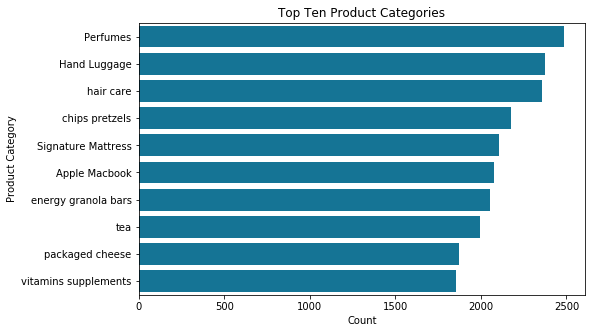

In [35]:
def product_categories():
    print(f"There are {olist_data.product_category_new.nunique()} categories")

    top_ten_categories = olist_data.product_category_new.value_counts().sort_values(ascending=False)[:10]

    plt.figure(figsize=(8,5))
    ax = sns.barplot(top_ten_categories.values, top_ten_categories.index, color=olist_blue)
    ax.set(xlabel='Count', ylabel='Product Category', title='Top Ten Product Categories');
    
    return

product_categories()

## Feature Engineering

When entering the site, the customers are flagged as a repeat customer or new customer and handled as follows.

**Repeat Customers:** Collaborative filtering is used to recommend products. Results are measured by how many predictions are right using the recommender vs. how many are right when just recommending the most popular item.

**For New Users:** Recommendation based on

Customer Segmentation, then pick the top product in that customer base <br>
People in your area, then pick the top products in that customer base <br>
Results are measured by comparing predictions to the overall most popular item <br>

In [36]:
def repeat_and_first_time(data):
    """Takes in a dataset and returns back the dataset with only repeated customers"""
    repeaters = data.groupby('customer_unique_id').filter(lambda x: len(x) > 1)
    first_timers = data.groupby('customer_unique_id').filter(lambda x: len(x) == 1)
    
    # Save datasets for easier accessing
    repeater_data.to_csv('repeater_data.csv')
    first_timer_data.to_csv('first_timer_data.csv')
    
    print("Shape of repeater dataset:", repeater_data.shape)

    print("Shape of first timer dataset:", first_timer_data.shape)

    return repeaters, first_timers

In [37]:
repeater_data =  olist_data.groupby('customer_unique_id').filter(lambda x: len(x) > 1)

In [38]:
first_timers = olist_data.groupby('customer_unique_id').filter(lambda x: len(x) == 1)

In [39]:
repeater_data.to_csv('repeater_data.csv')
first_timers.to_csv('first_timer_data.csv')

In [40]:
def regenerate_dataset_with_indicators(repeater_data, first_timers):
    repeater_data['repeater'] = 1
    first_timers['repeater'] = 0
    
    full_df = pd.concat((repeater_data, first_timers), axis=0).reset_index()
    print("full_df shape:", full_df.shape)
    return full_df

In [41]:
full_df = regenerate_dataset_with_indicators(repeater_data, first_timers)

full_df shape: (100851, 43)


# RECOMMENDATIONS FOR REPEAT CUSTOMERS :

The full data set is filtered down to only repeat customers. The goal is to predict the customers review on a product they have not purchased. Five methods are tested and compared: using only purchase count, using dummy variables, normalized purchase frequency, user ratings matrix, and normalized user ratings matrix.

## Preparing Dataframes

### Method 1: Purchase Count

In [42]:
def create_puchase_count_df(data):
    """
    Creates a dataset with customer_unique_id, _productId, and purchase count for that 
    user-product combination.
    """
    purchase_count = pd.melt(data.set_index('customer_unique_id')['product_id'].apply(pd.Series).reset_index(), 
                 id_vars=['customer_unique_id'],
                 value_name='product_id')
    purchase_count = purchase_count.dropna().drop(['variable'], axis=1)
    purchase_count = purchase_count.groupby(['customer_unique_id', 'product_id']).agg({'product_id': 'count'})
    purchase_count = purchase_count.rename(columns={'product_id': 'estimator'}).reset_index()
    purchase_count = purchase_count.rename(columns={'product_id': 'productId'})
    
    return purchase_count

In [43]:
purchase_count_df = create_puchase_count_df(repeater_data)

In [44]:
purchase_count_df.head()

,customer_unique_id,productId,estimator
0,C00006,P12312,1
1,C00006,P28372,1
2,C00010,P02020,2
3,C00020,P24082,2
4,C00039,P31888,2


In [45]:
len(purchase_count_df)

17420

In [46]:
purchase_count_df.shape

(17420, 3)

In [47]:
new = olist_data[['product_id','product_name']]

In [48]:
new.drop_duplicates(subset=['product_id'],inplace=True)

C:\Users\rachc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
new.shape

(29941, 2)

In [50]:
new.rename(columns={'product_id':'productId'}, inplace=True)

C:\Users\rachc\Anaconda3\lib\site-packages\pandas\core\frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [51]:
new

,productId,product_name
0,P20466,Utility Lighter
1,P04472,"Syrup, Maple Creme"
2,P27039,Vegan Alfredo Sauce Arugula Pesto
3,P00173,Disposal Cleaner
4,P24387,Light String Cheese
...,...,...
100836,P12211,Baby synch vest
100839,P10817,Baby tag you're it t
100840,P24717,L/s sol patrol shirt
100847,P21984,Bimini cap


In [52]:
purchase_count_df_new = pd.merge(purchase_count_df, new, on='productId', how='left')

In [53]:
purchase_count_df_new

,customer_unique_id,productId,estimator,product_name
0,C00006,P12312,1,Organic Ginger Herbal Tea
1,C00006,P28372,1,HE Turbo Powder Original Laundry Detergent
2,C00010,P02020,2,Elsa tunic
3,C00020,P24082,2,Chocolate Peanut Butter Builder's Bar
4,C00039,P31888,2,Quinoa Chips Barbeque
...,...,...,...,...
17415,C96954,P01013,2,Ice Shine Pro-V Shampoo
17416,C96954,P18418,2,Lemongrass Basil Chicken With Jasmine Rice
17417,C96985,P05269,1,100% Lemon Juice
17418,C96985,P08821,1,Grill Shakers Steak Seasoning Blend


### Method 2: Dummy Variables

In [54]:
def create_data_dummy(data):
    """
    Creates a dataset with customer_unique_id, _productId, and a binary indicator that the user 
    purchased that product.
    """
    data_dummy = data.copy()
    data_dummy['estimator2'] = 1
    data_dummy = data_dummy.drop('estimator', axis=1)
    data_dummy = data_dummy.rename({'estimator2':'estimator'}, axis=1)
    return data_dummy

In [55]:
dummy_df = create_data_dummy(purchase_count_df_new)

In [56]:
dummy_df

,customer_unique_id,productId,product_name,estimator
0,C00006,P12312,Organic Ginger Herbal Tea,1
1,C00006,P28372,HE Turbo Powder Original Laundry Detergent,1
2,C00010,P02020,Elsa tunic,1
3,C00020,P24082,Chocolate Peanut Butter Builder's Bar,1
4,C00039,P31888,Quinoa Chips Barbeque,1
...,...,...,...,...
17415,C96954,P01013,Ice Shine Pro-V Shampoo,1
17416,C96954,P18418,Lemongrass Basil Chicken With Jasmine Rice,1
17417,C96985,P05269,100% Lemon Juice,1
17418,C96985,P08821,Grill Shakers Steak Seasoning Blend,1


In [57]:
dummy_df_new = pd.merge(dummy_df, new, on='productId', how='left')

In [58]:
dummy_df_new

,customer_unique_id,productId,product_name_x,estimator,product_name_y
0,C00006,P12312,Organic Ginger Herbal Tea,1,Organic Ginger Herbal Tea
1,C00006,P28372,HE Turbo Powder Original Laundry Detergent,1,HE Turbo Powder Original Laundry Detergent
2,C00010,P02020,Elsa tunic,1,Elsa tunic
3,C00020,P24082,Chocolate Peanut Butter Builder's Bar,1,Chocolate Peanut Butter Builder's Bar
4,C00039,P31888,Quinoa Chips Barbeque,1,Quinoa Chips Barbeque
...,...,...,...,...,...
17415,C96954,P01013,Ice Shine Pro-V Shampoo,1,Ice Shine Pro-V Shampoo
17416,C96954,P18418,Lemongrass Basil Chicken With Jasmine Rice,1,Lemongrass Basil Chicken With Jasmine Rice
17417,C96985,P05269,100% Lemon Juice,1,100% Lemon Juice
17418,C96985,P08821,Grill Shakers Steak Seasoning Blend,1,Grill Shakers Steak Seasoning Blend


### Method 3: Normalize Purchase Frequency

In [59]:
def normalize_purchase_count(data):
    """
    Creates a dataset with customer_unique_id, _productId, and purchase count for that 
    user-product combination, and then normalized the data. 
    """
    count_matrix = pd.pivot_table(data, values='estimator', index='customer_unique_id', columns='productId')
    
    count_matrix_norm = (count_matrix-count_matrix.min())/(count_matrix.max()-count_matrix.min())
    count_matrix_norm = count_matrix_norm.reset_index()
    count_matrix_norm.index.names = ['scaled_purchase_freq']
    
    normalized_count_matrix = pd.melt(count_matrix_norm, id_vars=['customer_unique_id'], value_name='estimator').dropna()
    
    return normalized_count_matrix

In [60]:
normalized_purchase_count_df = normalize_purchase_count(purchase_count_df_new)

In [63]:
normalized_purchase_count_df.head()

,customer_unique_id,productId,estimator
48939,C04022,P00018,1.000000
56104,C62271,P00018,0.000000
109840,C07391,P00035,0.000000
115566,C54057,P00035,0.333333
115966,C57292,P00035,0.333333


In [64]:
normalized_purchase_count_df_new = pd.merge(normalized_purchase_count_df, new, on='productId', how='left')

In [65]:
normalized_purchase_count_df_new.head()

,customer_unique_id,productId,estimator,product_name
0,C04022,P00018,1.000000,Multigrain Penne Rigate
1,C62271,P00018,0.000000,Multigrain Penne Rigate
2,C07391,P00035,0.000000,Butternut Squash Pear Stage 2 Baby Food
3,C54057,P00035,0.333333,Butternut Squash Pear Stage 2 Baby Food
4,C57292,P00035,0.333333,Butternut Squash Pear Stage 2 Baby Food


## Method 4: User Ratings Matrix

In [66]:
def create_user_ratings_df(data):
    """Takes in a dataset and aggregates the review score for each product within each
    customer_unique_id."""
    user_prod_reviewscore_data = data.groupby(['customer_unique_id','product_id']
                                             )['review_score'].agg(['mean']).reset_index()
    
    user_prod_reviewscore_data = user_prod_reviewscore_data.rename({'mean':'estimator', 'product_id':'productId'}, 
                                                                   axis=1)
    
#     user_prod_reviewscore_data.avg_rating = user_prod_reviewscore_data.avg_rating.apply(lambda x: 1)
    
    return user_prod_reviewscore_data

In [67]:
user_ratings_df = create_user_ratings_df(repeater_data)

In [68]:
user_ratings_df.head()

,customer_unique_id,productId,estimator
0,C00006,P12312,3.0
1,C00006,P28372,4.0
2,C00010,P02020,4.0
3,C00020,P24082,4.0
4,C00039,P31888,4.0


In [69]:
user_ratings_df.shape

(17420, 3)

In [70]:
user_ratings_df_new = pd.merge(user_ratings_df, new, on='productId', how='left')

In [71]:
user_ratings_df_new.head()

,customer_unique_id,productId,estimator,product_name
0,C00006,P12312,3.0,Organic Ginger Herbal Tea
1,C00006,P28372,4.0,HE Turbo Powder Original Laundry Detergent
2,C00010,P02020,4.0,Elsa tunic
3,C00020,P24082,4.0,Chocolate Peanut Butter Builder's Bar
4,C00039,P31888,4.0,Quinoa Chips Barbeque


In [72]:
user_ratings_df_new.shape

(17420, 4)

## Method 5: Normalized User Ratings Matrix

In [73]:
def normalize_purchase_count(data):
    """Creates a user-ratings matrix but normalizes the ratings data."""
    ratings_matrix = pd.pivot_table(data, values='estimator', index='customer_unique_id', columns='productId')
    
    ratings_matrix_norm = (ratings_matrix-ratings_matrix.min())/(ratings_matrix.max()-ratings_matrix.min())
    ratings_matrix_norm = ratings_matrix_norm.reset_index()
    ratings_matrix_norm.index.names = ['estimator']
    
    normalized_ratings_matrix = pd.melt(ratings_matrix_norm, id_vars=['customer_unique_id'], value_name='estimator').dropna()
    
    return normalized_ratings_matrix

In [74]:
normalized_user_ratings_df = normalize_purchase_count(user_ratings_df_new)

In [75]:
normalized_user_ratings_df.head()

,customer_unique_id,productId,estimator
48939,C04022,P00018,1.0
56104,C62271,P00018,0.0
109840,C07391,P00035,0.5
115566,C54057,P00035,1.0
115966,C57292,P00035,0.0


In [76]:
normalized_user_ratings_df.shape

(8150, 3)

In [77]:
normalized_user_ratings_df_new = pd.merge(normalized_user_ratings_df, new, on='productId', how='left')

In [78]:
normalized_user_ratings_df_new.head()

,customer_unique_id,productId,estimator,product_name
0,C04022,P00018,1.0,Multigrain Penne Rigate
1,C62271,P00018,0.0,Multigrain Penne Rigate
2,C07391,P00035,0.5,Butternut Squash Pear Stage 2 Baby Food
3,C54057,P00035,1.0,Butternut Squash Pear Stage 2 Baby Food
4,C57292,P00035,0.0,Butternut Squash Pear Stage 2 Baby Food


In [79]:
normalized_user_ratings_df_new.shape

(8150, 4)

# Model Selection

Several different models are tested against each of the datasets created above. The model with the lowest RMSE is selected for additional tuning.

In [80]:
def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','productId','estimator']], reader)
    
    return df

# Split data into 5 kfolds
kf = KFold(n_splits=5, shuffle=True, random_state=19)

# Helper function to test different types of collaborative filtering
def model_framework(train_data):
    
    test_df = surprise_df(train_data)
    
    normp_rmse, svd_rmse, knn_rmse, co_rmse, slope_rmse = [], [], [], [], []

    for trainset, testset in kf.split(test_df): #iterate through the folds.
        
        #baseline
        normp = NormalPredictor()
        normp.fit(trainset)
        normp_pred = normp.test(testset)
        normp_rmse.append(accuracy.rmse(normp_pred,verbose=False))
        
        #svd
        svd = SVD(n_factors=30, n_epochs=50,biased=True, lr_all=0.005, reg_all=0.4, verbose=False)
        svd.fit(trainset)
        svd_pred = svd.test(testset)
        svd_rmse.append(accuracy.rmse(svd_pred,verbose=False))
        
        #knn
        knn = KNNBasic(k=40,sim_options={'name': 'cosine', 'user_based': False}, verbose=False) 
        knn.fit(trainset)
        knn_pred = knn.test(testset)
        knn_rmse.append(accuracy.rmse(knn_pred,verbose=False))
        
        #co_clustering
        co = CoClustering(n_cltr_u=3,n_cltr_i=3,n_epochs=20)         
        co.fit(trainset)
        co_pred = co.test(testset)
        co_rmse.append(accuracy.rmse(co_pred,verbose=False))
        
        #slope_one
        slope = SlopeOne() 
        slope.fit(trainset)
        slope_pred = slope.test(testset)
        slope_rmse.append(accuracy.rmse(slope_pred,verbose=False))
    
    mean_rmses = [np.mean(normp_rmse),
                  np.mean(svd_rmse),
                  np.mean(knn_rmse),
                  np.mean(co_rmse),
                  np.mean(slope_rmse)]
    
    model_names = ['baseline', 'svd','knn','coclustering','slopeone']
    compare_df = pd.DataFrame(mean_rmses, index=model_names)
    
    return compare_df

In [81]:
def model_comparison(all_methods):
    comp_matrix = model_framework(all_methods[0]).transpose()
    print('Initial dataframe created.')
    
    for method in all_methods[1:]:
        temp_df = model_framework(method).transpose()
        comp_matrix = pd.concat((comp_matrix,temp_df), axis=0)
        print("Layer added to dataframe.")
        
    comp_matrix = comp_matrix.set_index([['purchase_count', 
                                       'dummy',
                                       'norm_purchase_count', 
                                       'user_ratings', 
                                       'norm_user_ratings']])
    
    return comp_matrix

In [82]:
all_methods = [purchase_count_df_new, dummy_df_new, normalized_purchase_count_df_new, user_ratings_df_new, normalized_user_ratings_df_new]

In [83]:
comparison_matrix = model_comparison(all_methods)

Initial dataframe created.
Layer added to dataframe.


C:\Users\rachc\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Layer added to dataframe.
Layer added to dataframe.
Layer added to dataframe.


In [84]:
# create a column to indicate percentage better performance than baseline so that 
# centered and non-centered datasets can be compared
comparison_matrix['best_score'] = comparison_matrix.min(axis=1)
comparison_matrix['method_comparison'] = 100*(1-(comparison_matrix.best_score/comparison_matrix.baseline)) 
comparison_matrix

,baseline,svd,knn,coclustering,slopeone,best_score,method_comparison
purchase_count,1.681053,1.263056,1.312143,1.310423,1.279862,1.263056,24.865191
dummy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
norm_purchase_count,0.549634,0.451167,0.435789,0.442422,0.426369,0.426369,22.426693
user_ratings,2.005166,1.437593,1.518737,1.484639,1.420024,1.420024,29.181705
norm_user_ratings,0.559472,0.463423,0.434360,0.448460,0.417947,0.417947,25.296284


# Tuning Winning Model (SVD)

For the final model, will continue to leverage the user rating matrix as it requires minimal computational expense and maximum variance.

## Gridsearch

In [85]:
def gridsearch(data, model, param_grid):
    param_grid = param_grid
    gs = GridSearchCV(model, param_grid, measures=['rmse'], cv=5)
    gs.fit(data)
    
    new_params = gs.best_params['rmse']
    best_score = gs.best_score['rmse']
    
    print("Best score:", best_score)
    print("Best params:", new_params)
    
    return new_params, best_score

In [86]:
# standard svd gridsearch
data = surprise_df(user_ratings_df_new)

svd_param_grid = {'n_factors': [25,50,100],'n_epochs': [20,30,50], 'lr_all': [0.002,0.005,0.01],
              'reg_all':[0.02,0.1, 0.4]}

svd_params, svd_score = gridsearch(data, SVD, svd_param_grid)

Best score: 1.3903117894001915
Best params: {'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [87]:
svdpp_param_grid = {'n_factors': [10, 20, 50],'n_epochs': [20,30,50], 'lr_all': [0.002,0.007,0.01],
              'reg_all':[0.02,0.1, 0.4]}

svdpp_params, svdpp_score = gridsearch(data, SVDpp, svdpp_param_grid)

Best score: 1.3861475842914786
Best params: {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [88]:
def svd_model(data, model_list, model_names):
    all_scores = []
    
    for model in model_list:
        model_rmse = []
        model_mae = []
        
        for trainset, testset in kf.split(data): #iterate through the folds.

            mod = model
            mod.fit(trainset)
            pred = mod.test(testset)
            model_rmse.append(accuracy.rmse(pred,verbose=False))
            model_mae.append(accuracy.mae(pred,verbose=False))
            
        all_scores.append([np.mean(model_rmse), np.mean(model_mae)])
    
    results = pd.DataFrame(all_scores, index=model_names, columns=['rmse','mae'])
    
    return results

In [89]:
def svd_comparisons():
    # For comparison, baseline model
    random = NormalPredictor()

    # Standard SVD models
    tuned_svd = SVD(n_factors=svd_params['n_factors'], 
                    n_epochs=svd_params['n_epochs'],
                    lr_all=svd_params['lr_all'], 
                    reg_all=svd_params['reg_all'])

    standard_svd = SVD()

    # SVDpp moddels
    tuned_svdpp = SVDpp(n_factors=svdpp_params['n_factors'], 
                        n_epochs=svdpp_params['n_epochs'],
                        lr_all=svdpp_params['lr_all'], 
                        reg_all=svdpp_params['reg_all'])

    standard_svdpp = SVDpp()


    model_list = [random, tuned_svd, standard_svd, tuned_svdpp, standard_svdpp]
    model_names = ['random','tuned_svd','standard_svd','tuned_svdpp','standard_svdpp']

    return svd_model(data, model_list, model_names)

In [90]:
svd_comparison_df = svd_comparisons()
svd_comparison_df

,rmse,mae
random,1.994669,1.579188
tuned_svd,1.390283,1.169569
standard_svd,1.494664,1.291495
tuned_svdpp,1.385430,1.163898
standard_svdpp,1.472673,1.268174


In [91]:
svdpp_performance = 100*(1-(svd_comparison_df.loc['tuned_svdpp', 'rmse'] / svd_comparison_df.loc['random', 'rmse']))
print(f"Tuned SVDpp performed {svdpp_performance} better than baseline.")

Tuned SVDpp performed 30.54335899761074 better than baseline.


# Final Repeat Customer Model

In [99]:
def create_user_ratings_df(data):
    """Takes in a dataset and aggregates the review score for each product within each
    customer_unique_id."""
    user_prod_reviewscore_data = data.groupby(['customer_unique_id','product_id']
                                             )['review_score'].agg(['mean']).reset_index()
    
    user_prod_reviewscore_data = user_prod_reviewscore_data.rename({'mean':'estimator', 'product_id':'productId'}, 
                                                                   axis=1)
        
    return user_prod_reviewscore_data

def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','productId','estimator']], reader)
    
    return df

In [100]:
def final_model(data):
    user_product_df = create_user_ratings_df(data)
    user_ratings_matrix = surprise_df(user_product_df)
    
    train_set, test_set = train_test_split(user_ratings_matrix, test_size=0.1, random_state=19)
    
    params = {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1} 
    svdpp = SVDpp(n_factors=params['n_factors'], 
                    n_epochs=params['n_epochs'],
                    lr_all=params['lr_all'], 
                    reg_all=params['reg_all'])
    svdpp.fit(train_set)
    predictions = svdpp.test(test_set)
    rmse = accuracy.rmse(predictions,verbose=False)
            
    return predictions, rmse, train_set
    
final_predictions, final_rmse, train_set = final_model(repeater_data)

In [101]:
repeater_data

,Unnamed: 0,Unnamed: 0.1,order_id,payment_sequential,payment_type,payment_installments,order_status,order_purchase_timestamp,order_estimated_delivery_date,order_item_id,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,total_payment,product_name,product_category_new,repeater
9,9,9,ON56470,1,credit_card,10,delivered,11/28/2017 16:27,12/18/2017 0:00,2,...,PR80991,5,NaN,produto ótimo tudo muito bom só uma coisa eu n...,12/16/2017 0:00,12/18/2017 11:16,520.24,Wheat Free Blueberry Muffins,Love with food,1
10,10,10,ON56470,1,credit_card,10,delivered,11/28/2017 16:27,12/18/2017 0:00,1,...,PR80991,5,NaN,produto ótimo tudo muito bom só uma coisa eu n...,12/16/2017 0:00,12/18/2017 11:16,520.24,Kellogg's Pop-Tarts Frosted S'mores Pastries,Love with food,1
14,14,14,ON34004,1,boleto,1,delivered,8/4/2018 14:40,8/10/2018 0:00,1,...,PR08376,4,Bom,Chegou atrasado mas está valendo,8/15/2018 0:00,8/17/2018 5:10,126.23,100% Recycled 1-Ply Bathroom Tissue,MunchPak,1
37,37,37,ON25811,1,credit_card,1,delivered,7/27/2018 13:11,8/15/2018 0:00,2,...,PR59952,5,super recomendo,Produto exatamente conforme solicitação,8/1/2018 0:00,8/3/2018 18:00,1037.44,Ultra Comfort Care 2-Ply Double Rolls Toilet P...,packaged cheese,1
38,38,38,ON25811,1,credit_card,1,delivered,7/27/2018 13:11,8/15/2018 0:00,4,...,PR59952,5,super recomendo,Produto exatamente conforme solicitação,8/1/2018 0:00,8/3/2018 18:00,1037.44,Chorizo Hemp Soy-Free Tofu,packaged cheese,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100842,100842,100842,ON07748,1,credit_card,3,delivered,1/31/2018 21:22,2/23/2018 0:00,2,...,PR82775,5,NaN,NaN,2/10/2018 0:00,2/12/2018 14:19,457.32,Black Truffle Goat Cheese Log,Hand Luggage,1
100843,100843,100843,ON98785,1,credit_card,3,delivered,5/8/2018 21:04,5/29/2018 0:00,1,...,PR54011,5,NaN,NaN,5/22/2018 0:00,5/23/2018 22:43,358.02,Daily Moisture Quench Body Wash,chips pretzels,1
100844,100844,100844,ON98785,1,credit_card,3,delivered,5/8/2018 21:04,5/29/2018 0:00,2,...,PR54011,5,NaN,NaN,5/22/2018 0:00,5/23/2018 22:43,358.02,Daily Moisture Quench Body Wash,energy granola bars,1
100845,100845,100845,ON98785,1,credit_card,3,delivered,5/8/2018 21:04,5/29/2018 0:00,3,...,PR54011,5,NaN,NaN,5/22/2018 0:00,5/23/2018 22:43,358.02,Daily Moisture Quench Body Wash,paper goods,1


In [102]:
final_predictions

[Prediction(uid='C71088', iid='P10025', r_ui=5.0, est=4.3397781782485705, details={'was_impossible': False}),
 Prediction(uid='C88921', iid='P14134', r_ui=3.0, est=3.2872638479156056, details={'was_impossible': False}),
 Prediction(uid='C92824', iid='P28011', r_ui=5.0, est=4.236894907646205, details={'was_impossible': False}),
 Prediction(uid='C31650', iid='P10696', r_ui=4.0, est=3.546632834180919, details={'was_impossible': False}),
 Prediction(uid='C61824', iid='P22999', r_ui=4.0, est=3.6159319033659134, details={'was_impossible': False}),
 Prediction(uid='C17405', iid='P06326', r_ui=1.0, est=2.2130160571701394, details={'was_impossible': False}),
 Prediction(uid='C24131', iid='P08124', r_ui=5.0, est=3.7392430399893084, details={'was_impossible': False}),
 Prediction(uid='C48244', iid='P25134', r_ui=5.0, est=3.510265455386819, details={'was_impossible': False}),
 Prediction(uid='C18928', iid='P22148', r_ui=5.0, est=4.462064712780255, details={'was_impossible': False}),
 Prediction(ui

In [103]:
full_df

,index,Unnamed: 0,Unnamed: 0.1,order_id,payment_sequential,payment_type,payment_installments,order_status,order_purchase_timestamp,order_estimated_delivery_date,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,total_payment,product_name,product_category_new,repeater
0,9,9,9,ON56470,1,credit_card,10,delivered,11/28/2017 16:27,12/18/2017 0:00,...,PR80991,5,NaN,produto ótimo tudo muito bom só uma coisa eu n...,12/16/2017 0:00,12/18/2017 11:16,520.24,Wheat Free Blueberry Muffins,Love with food,1
1,10,10,10,ON56470,1,credit_card,10,delivered,11/28/2017 16:27,12/18/2017 0:00,...,PR80991,5,NaN,produto ótimo tudo muito bom só uma coisa eu n...,12/16/2017 0:00,12/18/2017 11:16,520.24,Kellogg's Pop-Tarts Frosted S'mores Pastries,Love with food,1
2,14,14,14,ON34004,1,boleto,1,delivered,8/4/2018 14:40,8/10/2018 0:00,...,PR08376,4,Bom,Chegou atrasado mas está valendo,8/15/2018 0:00,8/17/2018 5:10,126.23,100% Recycled 1-Ply Bathroom Tissue,MunchPak,1
3,37,37,37,ON25811,1,credit_card,1,delivered,7/27/2018 13:11,8/15/2018 0:00,...,PR59952,5,super recomendo,Produto exatamente conforme solicitação,8/1/2018 0:00,8/3/2018 18:00,1037.44,Ultra Comfort Care 2-Ply Double Rolls Toilet P...,packaged cheese,1
4,38,38,38,ON25811,1,credit_card,1,delivered,7/27/2018 13:11,8/15/2018 0:00,...,PR59952,5,super recomendo,Produto exatamente conforme solicitação,8/1/2018 0:00,8/3/2018 18:00,1037.44,Chorizo Hemp Soy-Free Tofu,packaged cheese,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100846,100840,100840,100840,ON72948,1,boleto,1,delivered,6/2/2018 20:13,7/13/2018 0:00,...,PR75573,5,Recomendo,"Muito bom o processo de compra, sem imprevisto...",6/15/2018 0:00,6/19/2018 2:35,52.75,L/s sol patrol shirt,spices seasonings,0
100847,100846,100846,100846,ON20609,1,credit_card,7,delivered,2/28/2018 10:14,3/27/2018 0:00,...,PR28493,5,NaN,otimos produtos \r\ntudo ok\r\nshow de bola,3/27/2018 0:00,4/3/2018 14:51,96.80,Frappuccino Chilled Coffee Drink,Hand Luggage,0
100848,100848,100848,100848,ON12593,1,credit_card,6,delivered,4/23/2017 16:59,5/17/2017 0:00,...,PR73958,5,NaN,NaN,5/4/2017 0:00,5/7/2017 11:30,237.14,Borderless messenger shorts,Apple Macbook,0
100849,100849,100849,100849,ON17375,1,credit_card,8,delivered,2/18/2018 17:33,3/12/2018 0:00,...,PR43440,3,NaN,"Excelente produto, correto, bem embalado mas c...",3/6/2018 0:00,3/6/2018 15:39,165.80,"Tall Kitchen Bags, Handle-Tie, 13 Gal",Perfumes,0


In [104]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(train_set.ur[train_set.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(train_set.ir[train_set.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

recommendation_results = pd.DataFrame(final_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
recommendation_results['No. of items rated by user'] = recommendation_results.uid.apply(get_Iu)
recommendation_results['No. of users that rated this item'] = recommendation_results.iid.apply(get_Ui)
recommendation_results['error'] = abs(recommendation_results.est - recommendation_results.rui)

In [106]:
recommendation_results.shape

(1742, 8)

In [107]:
best_predictions = recommendation_results.sort_values(by='error')[:10]
worst_predictions = recommendation_results.sort_values(by='error')[-10:]

In [108]:
best_predictions

,uid,iid,rui,est,details,No. of items rated by user,No. of users that rated this item,error
1408,C92489,P23910,5.0,5.000000,{'was_impossible': False},5,1,0.000000
947,C29158,P22673,5.0,5.000000,{'was_impossible': False},2,2,0.000000
1714,C15587,P10414,5.0,5.000000,{'was_impossible': False},3,2,0.000000
1676,C35916,P28986,4.0,3.999182,{'was_impossible': False},1,1,0.000818
1466,C70254,P09732,4.0,3.997120,{'was_impossible': False},1,8,0.002880
1411,C36725,P12837,4.0,3.994088,{'was_impossible': False},0,10,0.005912
1049,C90020,P31284,3.0,3.006080,{'was_impossible': False},0,1,0.006080
602,C55839,P12742,4.0,4.006724,{'was_impossible': False},1,0,0.006724
232,C20235,P06328,4.0,4.010808,{'was_impossible': False},1,0,0.010808
829,C09370,P06681,4.5,4.486931,{'was_impossible': False},2,1,0.013069


In [109]:
worst_predictions

,uid,iid,rui,est,details,No. of items rated by user,No. of users that rated this item,error
783,C25202,P14507,1.0,4.237018,{'was_impossible': False},0,7,3.237018
1030,C32141,P25453,1.0,4.274740,{'was_impossible': False},0,2,3.274740
897,C67196,P21567,1.0,4.279406,{'was_impossible': False},0,2,3.279406
1200,C93478,P08816,1.0,4.300564,{'was_impossible': False},1,0,3.300564
1028,C86348,P32601,1.0,4.301411,{'was_impossible': False},0,2,3.301411
448,C19855,P10728,1.0,4.305645,{'was_impossible': False},0,2,3.305645
961,C76986,P21201,1.0,4.360003,{'was_impossible': False},0,3,3.360003
1189,C28391,P09927,1.0,4.371968,{'was_impossible': False},0,3,3.371968
542,C92485,P04555,1.0,4.480108,{'was_impossible': False},2,0,3.480108
1502,C40637,P02786,1.0,4.716810,{'was_impossible': False},1,31,3.716810


In [110]:
recommendation_results1 = recommendation_results.copy()

In [111]:
recommendation_results1.rename(columns={'iid':'productId'}, inplace=True)

In [112]:
recommendation_results_new = pd.merge(recommendation_results1, new, on='productId', how='left')

In [113]:
recommendation_results_new

,uid,productId,rui,est,details,No. of items rated by user,No. of users that rated this item,error,product_name
0,C71088,P10025,5.0,4.339778,{'was_impossible': False},2,0,0.660222,"Noodle Soup, Shin Cup, Gourmet Spicy"
1,C88921,P14134,3.0,3.287264,{'was_impossible': False},0,1,0.287264,Flatbread Pizza All Natural Tomato Sauce Pizza...
2,C92824,P28011,5.0,4.236895,{'was_impossible': False},1,84,0.763105,"Clotted Cream, English Luxury"
3,C31650,P10696,4.0,3.546633,{'was_impossible': False},0,1,0.453367,Organic Raisin Bran Cereal
4,C61824,P22999,4.0,3.615932,{'was_impossible': False},1,6,0.384068,Vanilla Coconutmilk
...,...,...,...,...,...,...,...,...,...
1737,C36446,P01384,5.0,4.737340,{'was_impossible': False},1,18,0.262660,Yours Truly Chocolate Covered Cones
1738,C05429,P03621,2.5,3.380767,{'was_impossible': False},1,0,0.880767,Parmigiano Reggiano Marinara
1739,C07393,P25680,3.0,2.635643,{'was_impossible': False},0,2,0.364357,Premium Pork Sage Sausage
1740,C95427,P03185,1.0,3.754561,{'was_impossible': False},0,76,2.754561,Crystals Lavender Blossom In-Wash Fragrance Bo...


In [114]:
disp_rec = recommendation_results_new.copy()

In [115]:
disp_rec

,uid,productId,rui,est,details,No. of items rated by user,No. of users that rated this item,error,product_name
0,C71088,P10025,5.0,4.339778,{'was_impossible': False},2,0,0.660222,"Noodle Soup, Shin Cup, Gourmet Spicy"
1,C88921,P14134,3.0,3.287264,{'was_impossible': False},0,1,0.287264,Flatbread Pizza All Natural Tomato Sauce Pizza...
2,C92824,P28011,5.0,4.236895,{'was_impossible': False},1,84,0.763105,"Clotted Cream, English Luxury"
3,C31650,P10696,4.0,3.546633,{'was_impossible': False},0,1,0.453367,Organic Raisin Bran Cereal
4,C61824,P22999,4.0,3.615932,{'was_impossible': False},1,6,0.384068,Vanilla Coconutmilk
...,...,...,...,...,...,...,...,...,...
1737,C36446,P01384,5.0,4.737340,{'was_impossible': False},1,18,0.262660,Yours Truly Chocolate Covered Cones
1738,C05429,P03621,2.5,3.380767,{'was_impossible': False},1,0,0.880767,Parmigiano Reggiano Marinara
1739,C07393,P25680,3.0,2.635643,{'was_impossible': False},0,2,0.364357,Premium Pork Sage Sausage
1740,C95427,P03185,1.0,3.754561,{'was_impossible': False},0,76,2.754561,Crystals Lavender Blossom In-Wash Fragrance Bo...


In [116]:
del disp_rec['rui']
del disp_rec['est']
del disp_rec['details']

In [117]:
disp_rec

,uid,productId,No. of items rated by user,No. of users that rated this item,error,product_name
0,C71088,P10025,2,0,0.660222,"Noodle Soup, Shin Cup, Gourmet Spicy"
1,C88921,P14134,0,1,0.287264,Flatbread Pizza All Natural Tomato Sauce Pizza...
2,C92824,P28011,1,84,0.763105,"Clotted Cream, English Luxury"
3,C31650,P10696,0,1,0.453367,Organic Raisin Bran Cereal
4,C61824,P22999,1,6,0.384068,Vanilla Coconutmilk
...,...,...,...,...,...,...
1737,C36446,P01384,1,18,0.262660,Yours Truly Chocolate Covered Cones
1738,C05429,P03621,1,0,0.880767,Parmigiano Reggiano Marinara
1739,C07393,P25680,0,2,0.364357,Premium Pork Sage Sausage
1740,C95427,P03185,0,76,2.754561,Crystals Lavender Blossom In-Wash Fragrance Bo...


In [118]:
best_predictions1 = disp_rec.sort_values(by='error')[:10]

In [119]:
worst_predictions1 = disp_rec.sort_values(by='error')[-10:]

In [120]:
best_predictions1

,uid,productId,No. of items rated by user,No. of users that rated this item,error,product_name
1408,C92489,P23910,5,1,0.000000,Syrup Special Dark
947,C29158,P22673,2,2,0.000000,Gentle Iron 28mg Capsules
1714,C15587,P10414,3,2,0.000000,Chunky Blend Vegetable Beef Pilaf Baby Food
1676,C35916,P28986,1,1,0.000818,Cat Food
1466,C70254,P09732,1,8,0.002880,Everything Inside Bagels
1411,C36725,P12837,0,10,0.005912,Reduced Sodium Aluminum-Free Baking Powder
1049,C90020,P31284,0,1,0.006080,African Hot Pepper Sauce
602,C55839,P12742,1,0,0.006724,Muenster Slices
232,C20235,P06328,1,0,0.010808,Caramel Macchiato Coffee Creamer
829,C09370,P06681,2,1,0.013069,Lean Protein & Fiber Bar Chunky Chocolate Peanut


In [121]:
worst_predictions1

,uid,productId,No. of items rated by user,No. of users that rated this item,error,product_name
783,C25202,P14507,0,7,3.237018,Turkey Drumsticks
1030,C32141,P25453,0,2,3.274740,Original Wheat Crackers
897,C67196,P21567,0,2,3.279406,Lemonade With Tea
1200,C93478,P08816,1,0,3.300564,"Jalapeño String Cheese, Low Moisture Part Skim..."
1028,C86348,P32601,0,2,3.301411,Hardwood Floor Polish
448,C19855,P10728,0,2,3.305645,Angus Beef Meatballs
961,C76986,P21201,0,3,3.360003,Whole Kernel Corn
1189,C28391,P09927,0,3,3.371968,Stock In A Box All Natural Veggie Stock
542,C92485,P04555,2,0,3.480108,Classic Clean Shampoo
1502,C40637,P02786,1,31,3.716810,Sheep Milk Original Plain Kefir


In [122]:
disp_rec_repeat = pd.concat(g for _, g in disp_rec.groupby("uid") if len(g) > 1)

In [123]:
disp_rec_repeat

,uid,productId,No. of items rated by user,No. of users that rated this item,error,product_name
227,C00182,P29511,0,0,1.260757,Farmhouse Pancake & Waffle Mix
1233,C00182,P06909,0,0,1.260757,Chocolate Chunk Brownie
1216,C01804,P03339,0,0,1.260757,Zingers Cakes
1522,C01804,P07513,0,0,1.260757,Rosemary Parmesan Crackers
406,C02695,P03548,0,2,0.281130,Hot Thick & Chunky Salsa
...,...,...,...,...,...,...
1424,C91198,P24413,0,0,0.260757,Hardwood Slow Smoked Signature Pulled Pork
790,C95823,P19760,1,2,1.426158,Organic Potato Quinoa & Spinach Soup
1025,C95823,P23134,1,0,2.039678,Baked Scalloped Potatoes With Real Cheddar Che...
316,C95847,P19481,0,0,2.739243,Original Chocolate Flavor Fat Free Syrup


In [124]:
dups_color = disp_rec_repeat.pivot_table(index=['uid'], aggfunc='size')

In [138]:
dups_color.loc[dups_color.values == 2]

uid
C00182    2
C01804    2
C02695    2
C06411    2
C08634    2
         ..
C89967    2
C90165    2
C91198    2
C95823    2
C95847    2
Length: 70, dtype: int64

In [135]:
disp_rec

,uid,productId,No. of items rated by user,No. of users that rated this item,error,product_name
0,C71088,P10025,2,0,0.660222,"Noodle Soup, Shin Cup, Gourmet Spicy"
1,C88921,P14134,0,1,0.287264,Flatbread Pizza All Natural Tomato Sauce Pizza...
2,C92824,P28011,1,84,0.763105,"Clotted Cream, English Luxury"
3,C31650,P10696,0,1,0.453367,Organic Raisin Bran Cereal
4,C61824,P22999,1,6,0.384068,Vanilla Coconutmilk
...,...,...,...,...,...,...
1737,C36446,P01384,1,18,0.262660,Yours Truly Chocolate Covered Cones
1738,C05429,P03621,1,0,0.880767,Parmigiano Reggiano Marinara
1739,C07393,P25680,0,2,0.364357,Premium Pork Sage Sausage
1740,C95427,P03185,0,76,2.754561,Crystals Lavender Blossom In-Wash Fragrance Bo...


In [139]:
disp_rec.loc[disp_rec['uid'] == 'C40402']

,uid,productId,No. of items rated by user,No. of users that rated this item,error,product_name
185,C40402,P13659,1,0,0.922477,Stage 2 Sweet Potato Corn & Apple Baby Food
398,C40402,P28873,1,0,0.922477,Nacho Cheese Flavored Tortilla Chips
485,C40402,P26306,1,0,0.922477,Pretzels
1184,C40402,P15903,1,0,0.922477,Pearl Plastic Unscented Multipack


In [140]:
disp_rec.loc[disp_rec['uid'] == 'C56568']

,uid,productId,No. of items rated by user,No. of users that rated this item,error,product_name
380,C56568,P06598,0,0,1.260757,Kumquat
894,C56568,P30260,0,0,1.260757,"Cut Crystal 10\"" Plastic Plates"
1518,C56568,P09677,0,0,1.260757,Organic Vitality Snack Green Magic Chia


In [141]:
disp_rec.loc[disp_rec['uid'] == 'C00182']

,uid,productId,No. of items rated by user,No. of users that rated this item,error,product_name
227,C00182,P29511,0,0,1.260757,Farmhouse Pancake & Waffle Mix
1233,C00182,P06909,0,0,1.260757,Chocolate Chunk Brownie


In [142]:
disp_rec.loc[disp_rec['uid'] == 'C01804']

,uid,productId,No. of items rated by user,No. of users that rated this item,error,product_name
1216,C01804,P03339,0,0,1.260757,Zingers Cakes
1522,C01804,P07513,0,0,1.260757,Rosemary Parmesan Crackers


In [209]:
disp_rec.to_pickle('disp_rec.pkl')

In [210]:
best_predictions1.to_pickle('best_pred.pkl')

In [211]:
worst_predictions1.to_pickle('worst_pred.pkl')

In [168]:
full_df.to_pickle('full_df.pkl')

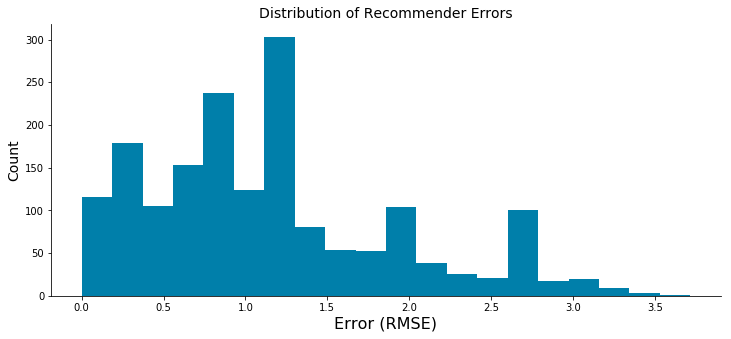

In [144]:
# plot model error
plt.figure(figsize=(12,5))
plt.hist(recommendation_results.error, color=olist_blue, bins=20)
plt.xlabel('Error (RMSE)', size=16)
plt.ylabel('Count', size=14)
plt.title('Distribution of Recommender Errors', size=14)
sns.despine();

In [145]:
def means_per_rating_group(dataset):
    real_over_three = dataset[dataset.rui > 3].error
    real_three_under = dataset[dataset.rui <= 3].error
    
    print("Overall recommendation system mean error:", dataset.error.mean())
    print("Mean error for products where user rates above 3:", real_over_three.mean())
    print("Mean error for products where user rates below 3:", real_three_under.mean())
    
    return real_over_three, real_three_under

real_over_three, real_three_under = means_per_rating_group(recommendation_results1)

Overall recommendation system mean error: 1.1655529679303949
Mean error for products where user rates above 3: 0.8654265153986026
Mean error for products where user rates below 3: 1.7281662518843826


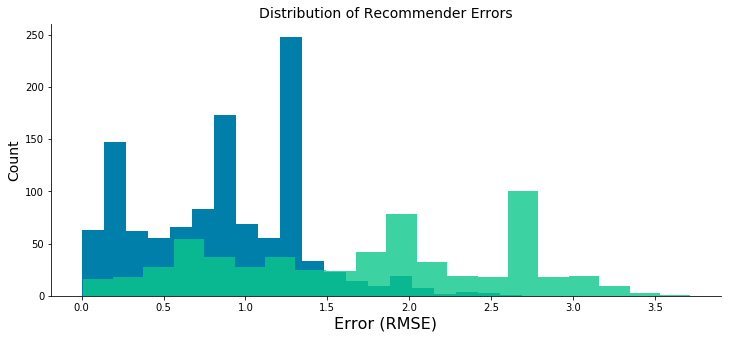

In [146]:
# plot the recommendation system mean for users who rate products higher than 3 and lower than 3
plt.figure(figsize=(12,5))
plt.hist(real_over_three, bins=20, color=olist_blue, label='Actual Rating >3')
plt.hist(real_three_under, bins=20, color=olist_green, alpha=.8, label='Actual Rating <=3')
plt.xlabel('Error (RMSE)', size=16)
plt.ylabel('Count', size=14)
plt.title('Distribution of Recommender Errors', size=14)
sns.despine();

In [147]:
recommendation_results_final = recommendation_results.copy()

In [148]:
recommendation_results_final

,uid,iid,rui,est,details,No. of items rated by user,No. of users that rated this item,error
0,C71088,P10025,5.0,4.339778,{'was_impossible': False},2,0,0.660222
1,C88921,P14134,3.0,3.287264,{'was_impossible': False},0,1,0.287264
2,C92824,P28011,5.0,4.236895,{'was_impossible': False},1,84,0.763105
3,C31650,P10696,4.0,3.546633,{'was_impossible': False},0,1,0.453367
4,C61824,P22999,4.0,3.615932,{'was_impossible': False},1,6,0.384068
...,...,...,...,...,...,...,...,...
1737,C36446,P01384,5.0,4.737340,{'was_impossible': False},1,18,0.262660
1738,C05429,P03621,2.5,3.380767,{'was_impossible': False},1,0,0.880767
1739,C07393,P25680,3.0,2.635643,{'was_impossible': False},0,2,0.364357
1740,C95427,P03185,1.0,3.754561,{'was_impossible': False},0,76,2.754561


In [149]:
recommendation_results_final.loc[recommendation_results_final['uid'] == 'C95823']

,uid,iid,rui,est,details,No. of items rated by user,No. of users that rated this item,error
790,C95823,P19760,4.0,2.573842,{'was_impossible': False},1,2,1.426158
1025,C95823,P23134,1.0,3.039678,{'was_impossible': False},1,0,2.039678


In [150]:
recommendation_results_final.rename(columns={'iid':'productId'}, inplace=True)

In [151]:
recommendation_results_final = pd.merge(recommendation_results1, new, on='productId', how='left')

In [152]:
recommendation_results_final.rename(columns={'iid':'productId','rui':'Actual Rating','est':'Predicted'}, inplace=True)

In [153]:
recommendation_results_final.loc[recommendation_results_final['uid'] == 'C95823']

,uid,productId,Actual Rating,Predicted,details,No. of items rated by user,No. of users that rated this item,error,product_name
790,C95823,P19760,4.0,2.573842,{'was_impossible': False},1,2,1.426158,Organic Potato Quinoa & Spinach Soup
1025,C95823,P23134,1.0,3.039678,{'was_impossible': False},1,0,2.039678,Baked Scalloped Potatoes With Real Cheddar Che...


In [154]:
del recommendation_results_final['Actual Rating']
del recommendation_results_final['details']
del recommendation_results_final['error']

In [155]:
recommendation_results_final

,uid,productId,Predicted,No. of items rated by user,No. of users that rated this item,product_name
0,C71088,P10025,4.339778,2,0,"Noodle Soup, Shin Cup, Gourmet Spicy"
1,C88921,P14134,3.287264,0,1,Flatbread Pizza All Natural Tomato Sauce Pizza...
2,C92824,P28011,4.236895,1,84,"Clotted Cream, English Luxury"
3,C31650,P10696,3.546633,0,1,Organic Raisin Bran Cereal
4,C61824,P22999,3.615932,1,6,Vanilla Coconutmilk
...,...,...,...,...,...,...
1737,C36446,P01384,4.737340,1,18,Yours Truly Chocolate Covered Cones
1738,C05429,P03621,3.380767,1,0,Parmigiano Reggiano Marinara
1739,C07393,P25680,2.635643,0,2,Premium Pork Sage Sausage
1740,C95427,P03185,3.754561,0,76,Crystals Lavender Blossom In-Wash Fragrance Bo...


In [156]:
recommendation_results_final1 = recommendation_results_final.copy()

In [157]:
del recommendation_results_final1['No. of items rated by user']
del recommendation_results_final1['No. of users that rated this item']

In [158]:
recommendation_results_final1

,uid,productId,Predicted,product_name
0,C71088,P10025,4.339778,"Noodle Soup, Shin Cup, Gourmet Spicy"
1,C88921,P14134,3.287264,Flatbread Pizza All Natural Tomato Sauce Pizza...
2,C92824,P28011,4.236895,"Clotted Cream, English Luxury"
3,C31650,P10696,3.546633,Organic Raisin Bran Cereal
4,C61824,P22999,3.615932,Vanilla Coconutmilk
...,...,...,...,...
1737,C36446,P01384,4.737340,Yours Truly Chocolate Covered Cones
1738,C05429,P03621,3.380767,Parmigiano Reggiano Marinara
1739,C07393,P25680,2.635643,Premium Pork Sage Sausage
1740,C95427,P03185,3.754561,Crystals Lavender Blossom In-Wash Fragrance Bo...


In [167]:
recommendation_results_final1.to_pickle('rec_res.pkl')

In [165]:
recommendation = first_time_recommender(full_df, 'C95823', 5)

Hot items you might like:
 ['Toasted Buttercrisp Crackers', 'Stainless Steel Water Bottle With Sport Cap, Aqua Color', 'Clotted Cream, English Luxury', 'Corn Pops Cereal', '8\\" Pepperoni Pizza']

Popular items in your area:
 ['8\\" Pepperoni Pizza', 'Toasted Buttercrisp Crackers', 'Corn Pops Cereal', 'Mangoes', 'Crystals Lavender Blossom In-Wash Fragrance Booster']


# First Time Users

In [161]:
def find_popular_items(data, n_recs):
    top_n_items = data.product_name.value_counts().sort_values(ascending=False)[:n_recs].index
    return list(top_n_items)

In [162]:
def popular_in_your_area(data, state, n_recs):
    location_df = data[data.customer_state == state]
    top_n_items = location_df.product_name.value_counts().sort_values(ascending=False)[:n_recs].index
    return list(top_n_items)

In [163]:
def first_time_recommender(data, uid, n_recs):
    hot_items = find_popular_items(data, n_recs)
    state = data[data.customer_unique_id==uid].customer_state.max()
    popular_in_area = popular_in_your_area(data, state, n_recs)
    
    print(f"Hot items you might like:\n {hot_items}\n")
    print(f"Popular items in your area:\n {popular_in_area}")
    
    recommendation = {'Hot Items': hot_items, 'Area': popular_in_area}
    
    return recommendation

In [166]:
# Example Recommendation
recommendation = first_time_recommender(full_df, 'C15383', 5)

Hot items you might like:
 ['Toasted Buttercrisp Crackers', 'Stainless Steel Water Bottle With Sport Cap, Aqua Color', 'Clotted Cream, English Luxury', 'Corn Pops Cereal', '8\\" Pepperoni Pizza']

Popular items in your area:
 ['Fresh Tomato & Basil Sauce', 'Traditional Non-Alcoholic Egg Nog', 'Sparkling Clementine Juice Beverage', 'Stainless Steel Water Bottle With Sport Cap, Aqua Color', 'Boo Chips']
